# Deep Domain Adaptation: Transfer one domain to another

<center>
<figure>
<img src="../_static/images/deep_da.png" alt="Deep DA">
    <figcaption>Deep Domain Adaptation from images of Amazon to Webcam pictures</figcaption>
</figure>
</center>

Deep learning approaches have proven to be very efficient nowadays, especially in visual computing. However, these approaches require a large amount of labeled data to be efficient. Obtaining labels for a new target dataset can be costly (an expert must annotate each image). However, in some cases, a similar dataset can be accessed with labels easily, the dataset however comes from another domain (source domain) and presents a shift with respect to the target dataset (e.g. a synthetically generated set of images compared to a real image dataset).

This is the case of the example we will study here on the [Office dataset](https://paperswithcode.com/dataset/office-31). We have on one side a real image dataset (taken by a webcam) of pictures of office items. These images are not labeled and we would like to learn a model to find their classes among 31 classes. On the other hand, we have an image dataset coming from the Amazon website, these images are annotated thanks to the website categories. The drawback is that the Amazon images have a plain background (usually white) which creates a shift compared to the webcam images (see Figure below). The idea is then to see if it is possible to adapt the domain of the Amazon images to the domain of the real images so that the task learned on Amazon generalizes well to the real images.

In [52]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [53]:
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.10.1
/device:GPU:0
Num GPUs Available:  2


2023-07-07 11:29:28.815061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-07 11:29:28.815467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-07 11:29:28.815782: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-07 11:29:28.816080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-07 11:29:28.816375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

The Office dataset can be downloaded [here](https://www.cc.gatech.edu/~judy/domainadapt/). We show below an example of the "back-pack" and "bike" classes on the "Amazon" and "Webcam" domains:

In [ ]:
path = "/nvme-pool/bil/kaggle3/" # path to downloaded Office dataset
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(plt.imread(path+"train/images/Agonidae/1a9c70c9-da38-4b3c-beac-9e9e5acbe26f.pngAgonidae0.png"))
ax2.imshow(plt.imread(path+"train/images/Actiniidae/0f8a9ac8-79ee-4b98-9662-149dfaa977d0.pngActiniidae0.png"))
ax1.set_title("label = back-pack"); ax2.set_title("label = bike");
plt.suptitle("Domain = Train"); plt.show()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(plt.imread(path+"test/images/Agonidae/f5b27eb8-ed0b-4dac-a022-655070676ea2.pngAgonidae0.png"))
ax2.imshow(plt.imread(path+"test/images/Actiniidae/0affe2a7-8e61-4abe-9309-599915d9248f.pngActiniidae0.png"))
ax1.set_title("label = back-pack"); ax2.set_title("label = bike");
plt.suptitle("Domain = Webcam"); plt.show()

## Dataset Preprocessing

We will first preprocess the dataset. We are going to use a [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50) as a base learning model. The idea will be to finetune the last block of the ResNet to make the adaptation rather than finetuning the whole ResNet. This way, we will reduce the computation time. We then extract, in preprocessing, the features corresponding to the output of the first blocks of the ReSNet50. These features are fixed and will be used as input for the model. We thus obtain two matrices `Xs` and `Xt` for the two domains Amazon and Webcam.

We first fetch the images of the two domains:

In [55]:
def get_Xy(domain, path_to_folder="/nvme-pool/bil/kaggle3/"):
    
    path = path_to_folder + domain
    X = []
    y = []

    for r, d, f in os.walk(path):
        #print('1')
        for direct in d:
            if not ".ipynb_checkpoints" in direct:
                for r, d, f in os.walk(os.path.join(path , direct)):
                    for file in f:
                        path_to_image = os.path.join(r, file)
                        if not ".ipynb_checkpoints" in path_to_image:
                            image = Image.open(path_to_image)
                            image = image.resize((224, 224), Image.ANTIALIAS)
                            image = np.array(image, dtype=int)
                            X.append(image)
                            y.append(direct)
    return X, y

Xs, ys = get_Xy("train")
#print(Xs)
Xt, yt = get_Xy("test")

/tmp/ipykernel_3751456/1911032291.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize((224, 224), Image.ANTIALIAS)


We will now split the ResNet into two parts, the first corresponding to the first fixed blocks and the second to the last block which will be finetuned.

In [57]:
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input

resnet50 = ResNet50(include_top=False, input_shape=(224, 224, 3), pooling="avg")

first_layer = resnet50.get_layer('conv5_block2_out')
inputs = Input(first_layer.output_shape[1:])

for layer in resnet50.layers[resnet50.layers.index(first_layer)+1:]:
    if layer.name == "conv5_block3_1_conv":
        x = layer(inputs)
    elif layer.name == "conv5_block3_add":
        x = layer([inputs, x])
    else:
        x = layer(x)

first_blocks = Model(resnet50.input, first_layer.output)
last_block = Model(inputs, x)

Here is the summary of the last block of the ResNet, (we don't display the first blocks summary to avoid overloading, but it's the same thing for 4 blocks). We also create a load function for the last block of the ResNet, in this function we set the `trainable` parameter of the `BatchNormalizationLayer` to `False` to avoid problems later during the fine-tuning (see [Tensorflow documentation](https://www.tensorflow.org/tutorials/images/transfer_learning))

In [58]:
def load_resnet50(path="resnet50_last_block.hdf5"):
    model = load_model(path)
    for i in range(len(model.layers)):
        if model.layers[i].__class__.__name__ == "BatchNormalization":
            model.layers[i].trainable = False
    return model

last_block.summary()
last_block.save("resnet50_last_block.hdf5")

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 7, 7, 2048)  0           []                               
                                ]                                                                 
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['input_14[0][0]']               
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block3_1_conv[1][0]']    
 ization)                                                                                         
                                                                                           

We can now extract the features of the first blocks of the ResNet50. We also onehotencode the labels.

In [59]:
from sklearn.preprocessing import OneHotEncoder

Xs = first_blocks.predict(preprocess_input(np.stack(Xs)))
Xt = first_blocks.predict(preprocess_input(np.stack(Xt)))

one = OneHotEncoder(sparse=False)
one.fit(np.array(ys).reshape(-1, 1))

ys_lab = one.transform(np.array(ys).reshape(-1, 1))
yt_lab = one.transform(np.array(yt).reshape(-1, 1))

print("X source shape: %s"%str(Xs.shape))
print("X target shape: %s"%str(Xt.shape))

182/182 [==============================] - 6s 33ms/step
X source shape: (4823, 7, 7, 2048)
X target shape: (5796, 7, 7, 2048)


/home/varshani/Documents/DA/.venv/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


We finally define a task network which will be put after the ResNet to classify between the 31 classes. Note that we use, in addition to dropout, a constraint on the norm of the weights of the network, we observed indeed that this constraint is necessary to obtain a good training of the adversarial domaina daptation method that we will use later. We use an SGD optimizer, we also define a decay on the learning rate `MyDecay`.

In [60]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.constraints import MaxNorm

def get_task(dropout=0.5, max_norm=0.5):
    model = Sequential()
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(31, activation="softmax",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    return model

In [61]:
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import SGD

class MyDecay(LearningRateSchedule):
    
    def __init__(self, max_steps=1000, mu_0=0.01, alpha=10, beta=0.75):
        self.mu_0 = mu_0
        self.alpha = alpha
        self.beta = beta
        self.max_steps = float(max_steps)

    def __call__(self, step):
        p = step / self.max_steps
        return self.mu_0 / (1+self.alpha * p)**self.beta

## Fit without adaptation

We will first fit the model without adaptation, i.e. we will finetune the ResNet50 on the source data only without using the target data. Note that we consider the target labels unknown, so we cannot use the target data in a classical supervised training.

In [62]:
lr = 0.04
momentum = 0.9
alpha = 0.0002

optimizer_task = SGD(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum, nesterov=True)
optimizer_enc = SGD(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum, nesterov=True)

In [63]:
from adapt.parameter_based import FineTuning

finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(Xs, 
              ys_lab, 
              epochs=16, 
              batch_size=32, 
              validation_data=(Xt, yt_lab))

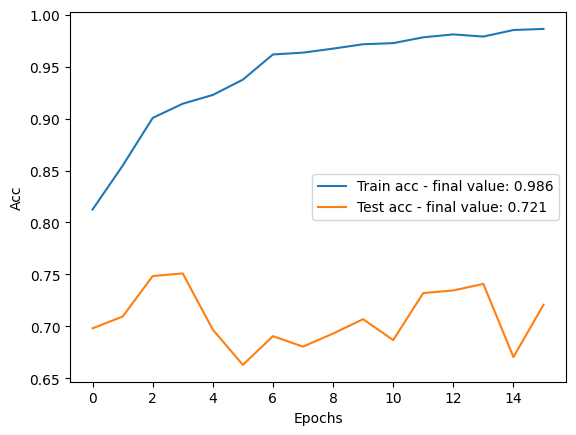

In [13]:
acc = finetunig.history.history["acc"]; val_acc = finetunig.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

As we can see, we get an accuracy around 75% on the target set which is already a good performance knowing that we used shifted data (Amazon data). It is interesting to visualize the encoded feature space, i.e. the one obtained at the output of the ResNet (see below). We can see that there are different clusters corresponding to the different classes for the source data, which shows that the encoded space learned by the ResNet is good for the classification task. However, we observe that these clusters are not aligned with the target data, which explains the loss of accuracy on the real target data.

In [ ]:
from sklearn.manifold import TSNE

Xs_enc = finetunig.transform(Xs)
Xt_enc = finetunig.transform(Xt)

np.random.seed(0)
X_ = np.concatenate((Xs_enc, Xt_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(Xs), 0], X_tsne[:len(Xs), 1], '.', label="source")
plt.plot(X_tsne[len(Xs):, 0], X_tsne[len(Xs):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the Source Only model")
plt.show()

## Fit with adaptation

Let's now apply a domain adaptation method to our problem of transfer between Amazon and Webcam. We will use the Maximum Disparity Discrepancy (MDD) method which is an adversarial domain adaptation method that currently obtains the best results for this type of problem. The idea of this method is based on a regularization of the model which forces the encoder to create a feature space in which the classification task can be learned easily on the sources and the source and target data are indistinguishable. This is achieved by training a third network similar to the task in an aadversarial fashion. For more details on the loss of the MDD model see the [ADAPT documentation](https://adapt-python.github.io/adapt/generated/adapt.feature_based.MDD.html) or the [Zangh's paper](https://arxiv.org/pdf/1904.05801.pdf).

In [26]:
# We shuffle the data, it may not be needed but we want to avoid classes being not represented
# in some batch due to the fact that the datasets are sorted by classes.
np.random.seed(0)
shuffle_src = np.random.choice(len(Xs), len(Xs), replace=False)
shuffle_tgt = np.random.choice(len(Xt), len(Xt), replace=False)

Xs = Xs[shuffle_src]
ys_lab = ys_lab[shuffle_src]
Xt = Xt[shuffle_tgt]
yt_lab = yt_lab[shuffle_tgt]

In [27]:
from adapt.feature_based import MDD
from adapt.utils import UpdateLambda

np.random.seed(123)
tf.random.set_seed(123)

lr = 0.04
momentum = 0.9
alpha = 0.0002

encoder = load_resnet50()
task = get_task()

optimizer_task = SGD(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum, nesterov=True)
optimizer_enc = SGD(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum, nesterov=True)
optimizer_disc = SGD(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))


mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=2.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

As we can see above, we have defined two networks `encoder` and `task` which are used by MDD. We set `copy=False` so that the `MDD` object does not make a copy of both networks, since our encoder is large we limit the memory space used. The `lambda_` parameter is the trade-off parameter between the classification loss and the regularization which brings the domains closer. This parameter is defined as a variable that will be gradually increased to `0.1` by the callback `UpdateLambda(lambda_max=0.1)`. This gradual change of the trade-off allows to start learning the classification task before trying to match the domains. The `gamma` parameter is a specific parameter of MDD. Finally, we use three optimizers for the three networks involved in MDD: the encoder, the task and the discriminator. The learning rate of the encoder and the discriminator are chosen to be 10 times lower than that of the task.

In the `fit` method, we use the data `Xs`, `ys_lab` and `Xt`. Note that `yt_lab` is not available in practice, it is used here to compute the accuracy on the targets but it is not used in the training of the model.

In [ ]:
mdd.fit(X=Xs[:-1], y=ys_lab[:-1], Xt=Xt, epochs=20, batch_size=32, validation_data=(Xt, yt_lab))

Let's now look at the results we get:

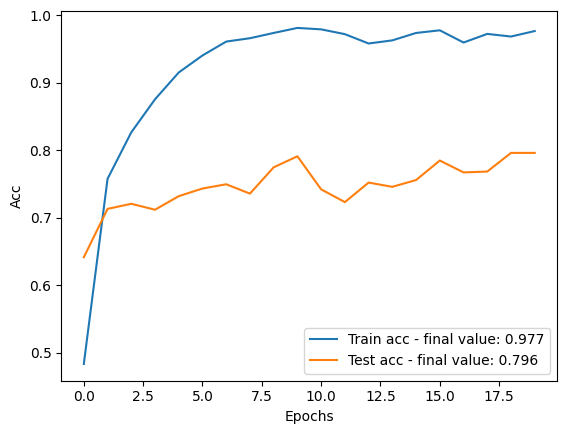

In [18]:
acc = mdd.history.history["acc"]; val_acc = mdd.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

Wow! You can see a clear gain in accuracy of more than 10% with the MDD method! It is very impressive since no target labels has been used. It is indeed the adaptation of the source domain on the target that allowed this gain in performance. This can be visualized in the encoded space: 

89/89 [==============================] - 1s 6ms/step


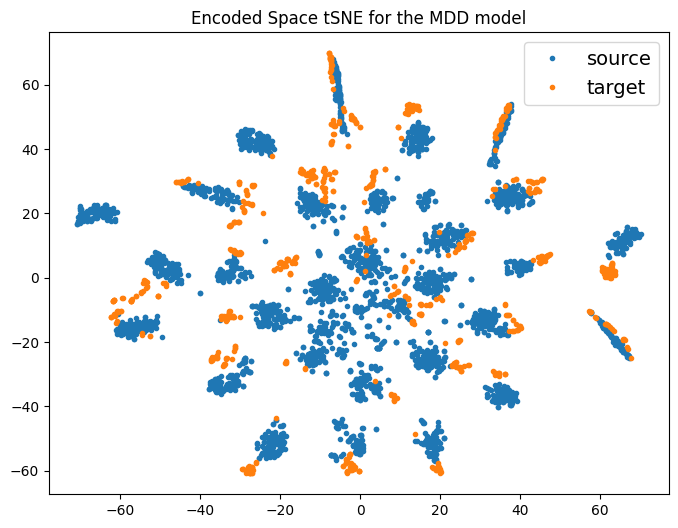

In [22]:
from sklearn.manifold import TSNE

Xs_enc = mdd.transform(Xs)
Xt_enc = mdd.transform(Xt)

np.random.seed(0)
X_ = np.concatenate((Xs_enc, Xt_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(Xs), 0], X_tsne[:len(Xs), 1], '.', label="source")
plt.plot(X_tsne[len(Xs):, 0], X_tsne[len(Xs):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the MDD model")
plt.show()

We clearly see that the target and the source data are now difficult to distinguish in the encoded space, MDD has succeeded in matching the two distributions. It is this distribution matching that causes this gain of performance.